# Visualization Demo

This is a notebook to demonsrate how to visualize the results of BackdoorBench by
* T-SNE
* Neuron Activation
* Shapley Value
* Grad Cam

## Step 0: Generate Results File (optional)

In this notebook, we visualize the result of Badnet Attack on Tiny imagenet with PreactResnet18 and poison ratio 5%. 
We assume that the results are stored in **'../record/tiny_preactresnet18_badnet_0_05'** which can be generated using the following command.


In [ ]:
! python -u ../defense/anp/anp.py --model preactresnet18 --result_file tiny_preactresnet18_badnet_0_05  --dataset tiny  --yaml_path ../config/defense/anp/tiny.yaml --index ../config/defense/index/tiny_index.txt

Note: it may take a few hours to generate the attack results depending on the device.

We also visualize the AC defense results and assume that the defense results are stored in **'../record/tiny_preactresnet18_badnet_0_05/ac**'

## Step 1: Load results

In [1]:
import sys, os
import yaml
import shap
import torch
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms

sys.path.append("../")
sys.path.append(os.getcwd())
from visual_utils import *
from utils.aggregate_block.dataset_and_transform_generate import (
    get_transform,
    get_dataset_denormalization,
)
from utils.aggregate_block.model_trainer_generate import generate_cls_model
from utils.bd_dataset import prepro_cls_DatasetBD
from utils.save_load_attack import load_attack_result
from pytorch_grad_cam import (
    GradCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    EigenCAM,
    FullGrad,
)
from pytorch_grad_cam.utils.image import show_cam_on_image
from utils.aggregate_block.fix_random import fix_random
from defense.dbd.model.utils import (
    get_network_dbd,
    load_state,
    get_criterion,
    get_optimizer,
    get_scheduler,
)
from defense.dbd.model.model import SelfModel, LinearModel

### 1. basic setting: args
def get_args():
    #set the basic parameter
    parser = argparse.ArgumentParser()
    
    parser.add_argument('--device', type=str, help='cuda, cpu')
    parser.add_argument('--yaml_path', type=str, default="../config/visualization/default.yaml", help='the path of yaml')
    parser.add_argument('--seed', type=str, help='random seed')
    parser.add_argument('--model', type=str, help='preactresnet18')

    # data parameters
    parser.add_argument("--dataset_path", type=str)
    parser.add_argument('--dataset', type=str, help='mnist, cifar10, cifar100, gtsrb, celeba, tiny') 
    parser.add_argument("--num_classes", type=int)
    parser.add_argument("--input_height", type=int)
    parser.add_argument("--input_width", type=int)
    parser.add_argument("--input_channel", type=int)
    parser.add_argument('--batch_size', type=int)
    parser.add_argument('--n_sub', default = 5000, type=int, help='number of samples for visualization')
    parser.add_argument('--c_sub', default = 10, type=int, help='number of class for visualization')
    parser.add_argument("--num_workers", default=2, type=float)
    parser.add_argument('--class_names', type=list, help='names for each class') 

    # BD parameters
    parser.add_argument('--pratio', type=float)
    parser.add_argument('--attack_target', type=int)
    parser.add_argument('--index', type=str, help='index of clean data')

    # results parameters
    parser.add_argument('--result_file_attack', type=str, help='the location of attack result')
    parser.add_argument('--result_file_defense', type=str, help='the location of defense result')
    parser.add_argument('--checkpoint_load', type=str)
    parser.add_argument('--checkpoint_save', type=str)

    arg = parser.parse_args([])
    return arg

args = get_args()
with open(args.yaml_path, "r") as stream:
    config = yaml.safe_load(stream)
config.update({k: v for k, v in args.__dict__.items() if v is not None})
args.__dict__ = config
args.result_file_attack = "tiny_preactresnet18_badnet_0_05"
args.result_file_defense =  "tiny_preactresnet18_badnet_0_05/dbd"
args.dataset = "tiny"
args.pratio = 0.05
args = preprocess_args(args)
fix_random(int(args.random_seed))

save_path_attack = "../record/" + args.result_file_attack
if args.result_file_defense!='None':
    save_path_defense = "../record/" + args.result_file_defense

# Load data
result_attack = load_attack_result(save_path_attack + "/attack_result.pt")
x = result_attack["clean_test"]["x"]
y = result_attack["clean_test"]["y"]
x_bd = result_attack["bd_test"]["x"]
y_bd = result_attack["bd_test"]["y"]
bd_clean_idx = result_attack["bd_test"]["original_index"]
y_bd_clean = y[bd_clean_idx]
x_bd_clean = [x[i] for i in bd_clean_idx]

# Load model
model_attack = generate_cls_model(args.model, args.num_classes)
model_attack.load_state_dict(result_attack["model"])
model_attack.to(args.device)

if args.result_file_defense != "None":
    result_defense = load_attack_result(save_path_defense + "/defense_result.pt")
    model_defense = generate_cls_model(args.model, args.num_classes)
    defense_method = args.result_file_defense.split('/')[-1]
    if defense_method=='fp':
        model_defense.layer4[1].conv2 = nn.Conv2d(512, 512 - result_defense['index'], (3, 3), stride=1, padding=1, bias=False)
        model_defense.linear = nn.Linear((512 - result_defense['index'])*1, args.num_classes)
    if defense_method=='dbd':
        backbone = get_network_dbd(args)
        model_defense = LinearModel(backbone, backbone.feature_dim, args.num_classes)
    model_defense.load_state_dict(result_defense["model"])
    model_defense.to(args.device)
    model_defense.eval()


criterion = nn.CrossEntropyLoss()
tran = get_transform(args.dataset, *([args.input_height, args.input_width]), train=False)

# subsample classes for visualization if necessary
if args.num_classes > args.c_sub:
    # subsample c_sub classes
    class_sub = 1 + np.random.choice(args.num_classes - 1, size=args.c_sub - 1, replace=False)
    class_sub = class_sub.tolist()
    class_sub.append(args.attack_target)
    x, y = sample_by_classes(x, y, class_sub)
    x_bd, y_bd = sample_by_classes(x_bd, y_bd_clean, class_sub)
    x_bd_clean, y_bd_clean = sample_by_classes(x_bd_clean, y_bd_clean, class_sub)

# subsample clean images for visualization
n = len(x)
n_sub = args.n_sub
# subsample clean data
if n > n_sub:
    sub_bin = int(n / n_sub)
    sub_idx = np.argsort(y)[::sub_bin]
    y_sub = y[sub_idx]
    x_sub = [x[i] for i in sub_idx]
else:
    y_sub = y
    x_sub = x

# subsample pratio poison images for visualization
n_sub_bd = int(len(x_sub) * args.pratio)
sub_bin_bd = int(n / n_sub_bd)
sub_idx_bd = np.argsort(y_bd)[::sub_bin_bd]
x_bd_sub = [x_bd[i] for i in sub_idx_bd]
y_bd_sub = y_bd[sub_idx_bd]

# original label
y_bd_clean_sub = np.copy(y_bd_sub)
# poison label
y_bd_sub[:] = args.num_classes

# combine all subsamples
x_v = x_sub + x_bd_sub
y_v = np.concatenate([y_sub, y_bd_sub])
y_v_clean = np.concatenate([y_sub, y_bd_clean_sub])


# build data loader
data_set = list(zip(x_v, y_v))

data_set_o = prepro_cls_DatasetBD(
    full_dataset_without_transform=data_set,
    poison_idx=np.zeros(
        len(data_set)
    ),  # no further poison steps for visualization data
    bd_image_pre_transform=None,
    bd_label_pre_transform=None,
    ori_image_transform_in_loading=tran,
    ori_label_transform_in_loading=None,
    add_details_in_preprocess=False,
)
data_loader = torch.utils.data.DataLoader(
    data_set_o, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=False
)

for trans_t in data_loader.dataset.ori_image_transform_in_loading.transforms:
    if isinstance(trans_t, transforms.Normalize):
        denormalizer = get_dataset_denormalization(trans_t)


resize: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 48903.59it/s]


loading...


location : ../record/tiny_preactresnet18_badnet_0_05/attack_result.pt, content summary :{'bd_test': {'original_index': {'max': 9999, 'min': 50, 'shape': (9950,)},
             'original_targets': {'max': 199, 'min': 1, 'shape': (9950,)},
             'x': {'first ten': [<PIL.Image.Image image mode=RGB size=64x64 at 0x7F02E901CCA0>,
                                 <PIL.Image.Image image mode=RGB size=64x64 at 0x7F02E9023DC0>,
                                 <PIL.Image.Image image mode=RGB size=64x64 at 0x7F02E902A3A0>,
                                 <PIL.Image.Image image mode=RGB size=64x64 at 0x7F02E902A160>,
                                 <PIL.Image.Image image mode=RGB size=64x64 at 0x7F02E902A2E0>,
                                 <PIL.Image.Image image mode=RGB size=64x64 at 0x7F02E902A9A0>,
                                 <PIL.Image.Image image mode=RGB size=64x64 at 0x7F02E902A760>,
                                 <PIL.Image.Image image mode=RGB size=64x64 at 0x7F02E902A

pre-process bd dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 523/523 [00:00<00:00, 26273.43it/s]


## Visualize some images

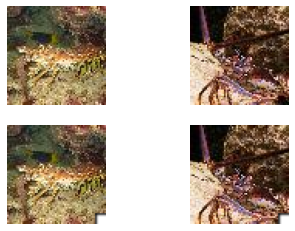

In [19]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_bd_clean[0])
axarr[0,1].imshow(x_bd_clean[1])
axarr[1,0].imshow(x_bd[0])
axarr[1,1].imshow(x_bd[1])
for ax in axarr.flatten():
    ax.axis("off")

## Step 2: Visualization

### 2.1: T-SNE

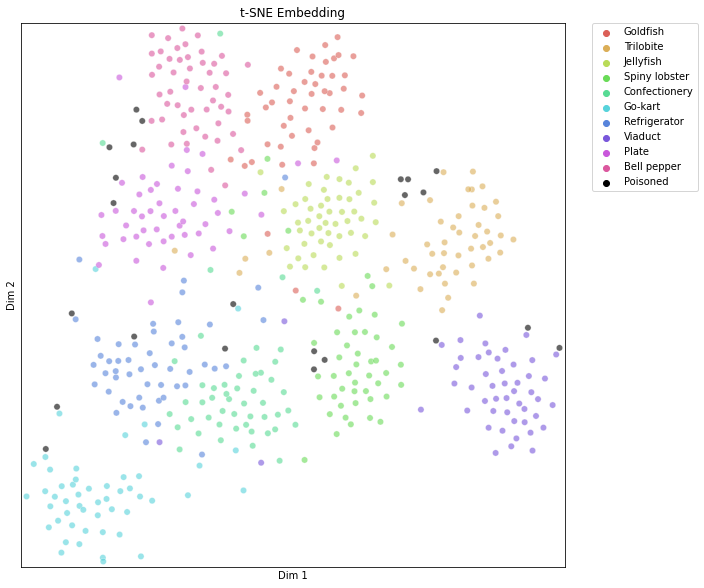

In [20]:
# Attack Plot
# Choose layer for feature extraction
if args.model == "preactresnet18":
    target_layer = model_attack.layer4
if args.model == "vgg19":
    target_layer = model_attack.features[-1]
if args.model == "resnet18":
    target_layer = model_attack.layer4
if args.model == "densenet161":
    target_layer = model_attack.features[-1]
if args.model == "mobilenet_v3_large":
    target_layer = model_attack.features[-1]
if args.model == "efficientnet_b3":
    target_layer = model_attack.features[-1]


features, labels = get_features(args, model_attack, target_layer, data_loader)

sort_idx = np.argsort(labels)
features = features[sort_idx]
labels = labels[sort_idx]
classes = args.class_names + ["poisoned"]
label_class = [classes[i].capitalize() for i in labels]

# Plot T-SNE
custom_palette = sns.color_palette("hls", 10) + [
    (0.0, 0.0, 0.0)
]  # Black for poison samples
fig = tsne_fig(
    features,
    label_class,
    title="t-SNE Embedding",
    xlabel="Dim 1",
    ylabel="Dim 2",
    custom_palette=custom_palette,
    size = (10,10)
)
plt.savefig(save_path_attack + f"/{args.result_file_attack.replace('/','_')}_tsne.png", bbox_inches='tight')

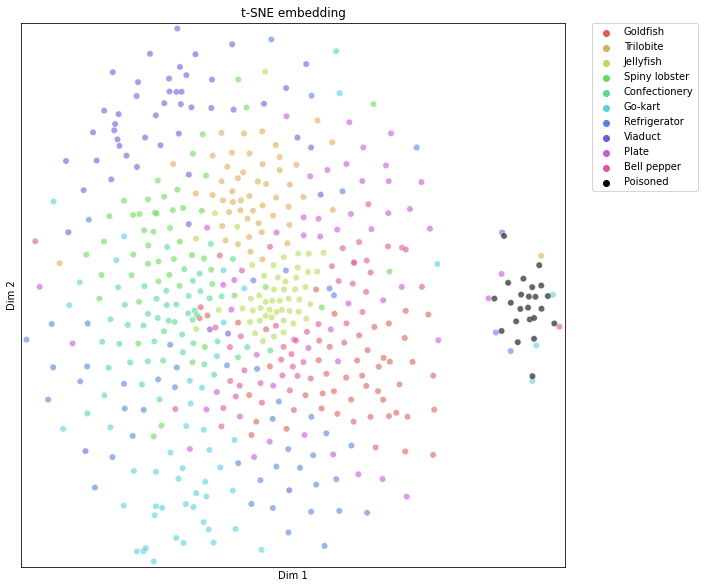

In [21]:
if args.result_file_defense!='None':
    # Defense Plot
    # Choose layer for feature extraction
    if args.model == "preactresnet18":
        target_layer = model_defense.backbone.layer4 if defense_method=='dbd' else model_defense.layer4
    if args.model == "vgg19":
        target_layer = model_defense.backbone.features if defense_method=='dbd' else model_defense.features
    if args.model == "resnet18":
        target_layer = model_defense.backbone.layer4 if defense_method=='dbd' else model_defense.layer4
    if args.model == "densenet161": 
        target_layer = model_defense.backbone.features if defense_method=='dbd' else model_defense.features
    if args.model == "mobilenet_v3_large": 
        target_layer = model_defense.backbone.features if defense_method=='dbd' else model_defense.features
    if args.model == "efficientnet_b3":
        target_layer = model_defense.backbone.features if defense_method=='dbd' else model_defense.features

    features_defense, labels_defense = get_features(args, model_defense, target_layer, data_loader)

    sort_idx = np.argsort(labels_defense)
    features_defense = features_defense[sort_idx]
    labels_defense = labels_defense[sort_idx]
    classes = args.class_names + ["poisoned"]
    label_class_defense = [classes[i].capitalize() for i in labels_defense]

    # Plot T-SNE
    custom_palette = sns.color_palette("hls", 10) + [
        (0.0, 0.0, 0.0)
    ]  # Black for poison samples
    fig = tsne_fig(
        features_defense,
        label_class_defense,
        title="t-SNE embedding",
        xlabel="Dim 1",
        ylabel="Dim 2",
        custom_palette=custom_palette,
        size=(10,10)
    )
    plt.savefig(save_path_defense + f"/{args.result_file_defense.replace('/','_')}_tsne.png", bbox_inches='tight')


# Neuron Activation

In [5]:
data_set_clean = list(zip(x_bd_clean, y_bd_clean))
data_set_bd = list(zip(x_bd, y_bd))

data_set_clean = prepro_cls_DatasetBD(
    full_dataset_without_transform=data_set_clean,
    poison_idx=np.zeros(
        len(data_set_clean)
    ),  # no further poison steps for visualization data
    bd_image_pre_transform=None,
    bd_label_pre_transform=None,
    ori_image_transform_in_loading=tran,
    ori_label_transform_in_loading=None,
    add_details_in_preprocess=False,
)

data_set_bd = prepro_cls_DatasetBD(
    full_dataset_without_transform=data_set_bd,
    poison_idx=np.zeros(
        len(data_set_bd)
    ),  # no further poison steps for visualization data
    bd_image_pre_transform=None,
    bd_label_pre_transform=None,
    ori_image_transform_in_loading=tran,
    ori_label_transform_in_loading=None,
    add_details_in_preprocess=False,
)


data_loader_clean = torch.utils.data.DataLoader(
    data_set_clean, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=False
)
data_loader_bd = torch.utils.data.DataLoader(
    data_set_bd, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=False
)


pre-process bd dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:00<00:00, 33136.18it/s]


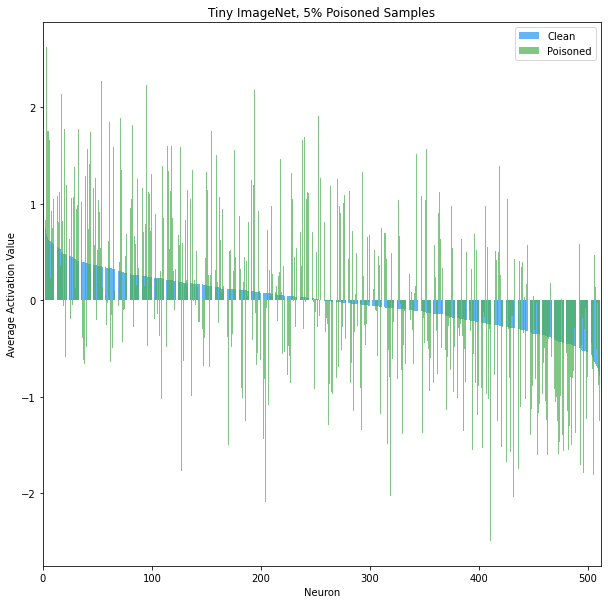

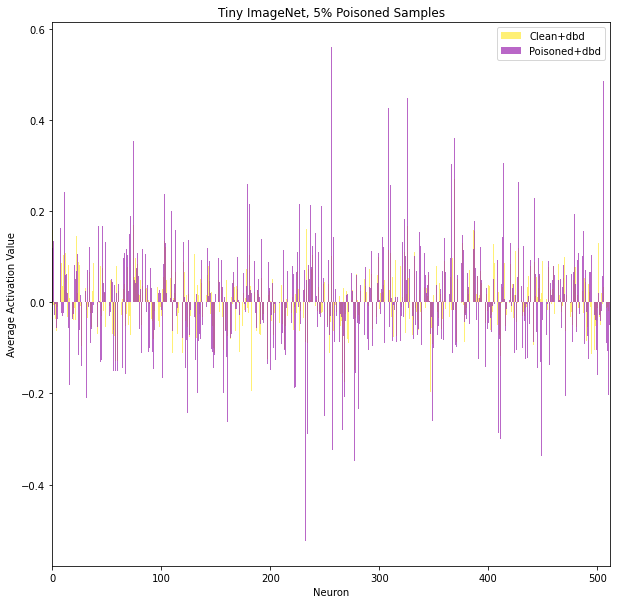

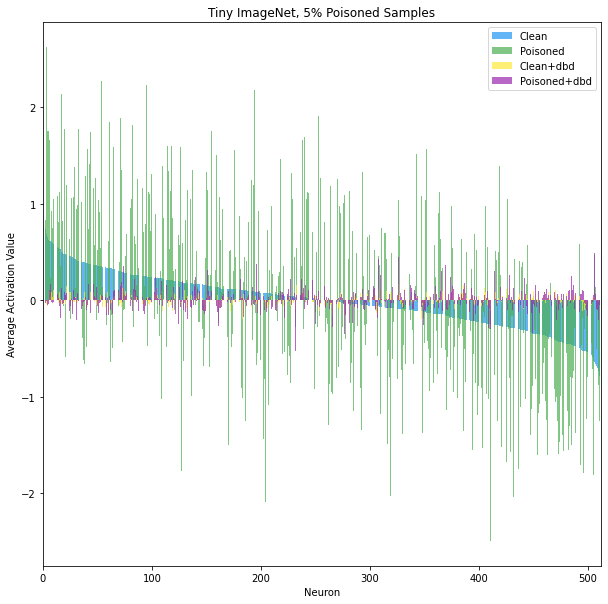

In [6]:
# Choose layer for feature extraction for Attack
if args.model == "preactresnet18":
    target_layer = model_attack.avgpool
if args.model == "vgg19":
    target_layer = model_attack.avgpool
if args.model == "resnet18":
    target_layer = model_attack.avgpool
if args.model == "densenet161":
    target_layer = model_attack.features[-1]
if args.model == "mobilenet_v3_large":
    target_layer = model_attack.features[-1]
if args.model == "efficientnet_b3":
    target_layer = model_attack.features[-1]

info_list = args.result_file_attack.split('_')

features_clean, labels_clean = get_features(args, model_attack, target_layer, data_loader_clean)
features_clean_avg = np.mean(features_clean, axis =0)

features_bd, labels_bd = get_features(args, model_attack, target_layer, data_loader_bd)
features_bd_avg = np.mean(features_bd, axis =0)

sort_bar = np.argsort(features_clean_avg)[::-1]

features_bd_avg=features_bd_avg[sort_bar]
features_clean_avg=features_clean_avg[sort_bar]

plt.figure(figsize=(10,10))
plt.bar(np.arange(features_clean_avg.shape[0]),features_clean_avg, label="Clean", alpha =0.7, color = "#2196F3")
plt.bar(np.arange(features_bd_avg.shape[0]),features_bd_avg, label="Poisoned", alpha =0.7, color = "#4CAF50")
plt.xlabel("Neuron")
plt.ylabel("Average Activation Value")
plt.title(f"{get_dataname(args.dataset)}, {get_pratio(args.pratio)}% Poisoned Samples")
plt.xlim(0, features_clean_avg.shape[0])
plt.legend()
plt.savefig(save_path_attack+ f"/{args.result_file_attack.replace('/','_')}neuron.png")

if args.result_file_defense!='None':

    # Choose layer for feature extraction for Defense
    if args.model == "preactresnet18":
        target_layer = model_defense.backbone.avgpool if defense_method=='dbd' else model_defense.avgpool
    if args.model == "vgg19":
        target_layer = model_defense.backbone.avgpool if defense_method=='dbd' else model_defense.avgpool
    if args.model == "resnet18":
        target_layer = model_defense.backbone.avgpool if defense_method=='dbd' else model_defense.avgpool
    if args.model == "densenet161":
        target_layer = model_defense.backbone.features[-1] if defense_method=='dbd' else model_defense.features[-1]
    if args.model == "mobilenet_v3_large":
        target_layer = model_defense.backbone.features[-1] if defense_method=='dbd' else model_defense.features[-1]
    if args.model == "efficientnet_b3":
        target_layer = model_defense.backbone.features[-1] if defense_method=='dbd' else model_defense.features[-1]

    features_clean_defense, labels_clean_defense = get_features(args, model_defense, target_layer, data_loader_clean)
    features_clean_avg_defense = np.mean(features_clean_defense, axis =0)

    features_bd_defense, labels_bd_defense = get_features(args, model_defense, target_layer, data_loader_bd)
    features_bd_avg_defense = np.mean(features_bd_defense, axis =0)
    
    plt.figure(figsize=(10,10))
    features_bd_avg_defense=features_bd_avg_defense[sort_bar]
    features_clean_avg_defense=features_clean_avg_defense[sort_bar]
    dn = get_defensename(args.result_file_defense.split('/')[-1])
    plt.bar(np.arange(features_clean_avg_defense.shape[0]),features_clean_avg_defense, label="Clean+"+dn, alpha =0.7, color = "#FFEB3B")
    plt.bar(np.arange(features_bd_avg_defense.shape[0]),features_bd_avg_defense, label="Poisoned+"+dn, alpha =0.7, color = "#9C27B0")    
    plt.xlabel("Neuron")
    plt.ylabel("Average Activation Value")
    plt.title(f"{get_dataname(args.dataset)}, {get_pratio(args.pratio)}% Poisoned Samples")
    plt.xlim(0, features_clean_avg_defense.shape[0])
    plt.legend()
    plt.savefig(save_path_defense + f"/{args.result_file_defense.replace('/','_')}neuron.png")
    
    plt.figure(figsize=(10,10))
    plt.bar(np.arange(features_clean_avg.shape[0]),features_clean_avg, label="Clean", alpha =0.7, color = "#2196F3")
    plt.bar(np.arange(features_bd_avg.shape[0]),features_bd_avg, label="Poisoned", alpha =0.7, color = "#4CAF50")
    plt.bar(np.arange(features_clean_avg_defense.shape[0]),features_clean_avg_defense, label="Clean+"+dn, alpha =0.7, color = "#FFEB3B")
    plt.bar(np.arange(features_bd_avg_defense.shape[0]),features_bd_avg_defense, label="Poisoned+"+dn, alpha =0.7, color = "#9C27B0")
    plt.xlabel("Neuron")
    plt.ylabel("Average Activation Value")
    plt.title(f"{get_dataname(args.dataset)}, {get_pratio(args.pratio)}% Poisoned Samples")
    plt.legend()
    #plt.ylim(-0.7, 1.0)
    plt.xlim(0, features_clean_avg_defense.shape[0])
    plt.savefig(save_path_defense + f"/{args.result_file_defense.replace('/','_')}_neuron_compare.png")


### 2.2 SHAP Value

# Gradient SHAP: Explain an Intermediate Layer 
Gradient SHAP is a gradient method to compute SHAP values, which are based on Shapley values proposed in cooperative game theory. Gradient SHAP adds Gaussian noise to each input sample multiple times, selects a random point along the path between baseline and input, and computes the gradient of outputs with respect to those selected random points. The final SHAP values represent the expected value of gradients.

The computed attributions approximate SHAP values under the assumptions that the input features are independent and that the explanation model is linear between the inputs and given baselines.

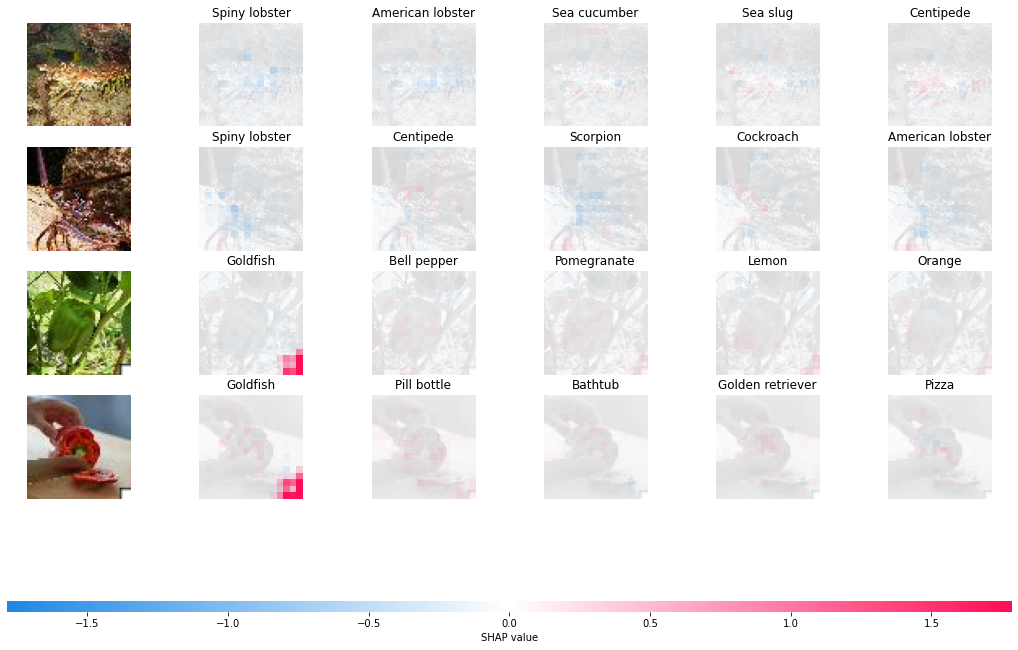

In [7]:
full_image = []
full_target = []
for batch_idx, (inputs, targets) in enumerate(data_loader):
    full_image.append(inputs)
    full_target.append(targets)
full_image_t = torch.cat(full_image, 0)
full_target_t = torch.cat(full_target, 0)

# choose data for visualization
n_v = 200
v_idx = np.random.choice(full_image_t.shape[0] - 4, n_v, replace=False)
background = full_image_t[2 + v_idx].to(args.device)
# background = full_image_t[-200:].to(args.device)

# 2 clean image + 2 poisoned image
test_images = torch.cat([full_image_t[:2], full_image_t[-2:]]).to(args.device)
# Get clean label for all test image
test_label = np.concatenate([y_v_clean[:2], y_v_clean[-2:]])

sfm = nn.Softmax(dim=1)


# Choose layer for SHAP
if args.model == "preactresnet18":
    target_layer = model_attack.layer4
if args.model == "vgg19":
    target_layer = model_attack.features
if args.model == "resnet18":
    target_layer = model_attack.layer4
if args.model == "densenet161":
    target_layer = model_attack.features
if args.model == "mobilenet_v3_large":
    target_layer = model_attack.features
if args.model == "efficientnet_b3":
    target_layer = model_attack.features

model_attack.eval()

outputs = model_attack(test_images)
pre_p, pre_label = torch.max(sfm(outputs), dim=1)

e = shap.GradientExplainer((model_attack, target_layer), background, local_smoothing=0)
shap_values, indexes = e.shap_values(test_images, ranked_outputs=5)

# get the names for the classes
class_names = np.array(args.class_names).reshape([-1])
index_names = np.vectorize(lambda x: class_names[x].capitalize())(indexes.cpu())
# plot the explanations
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(
    np.swapaxes(denormalizer(test_images.cpu()).numpy(), 1, -1), 1, 2
)
test_numpy[test_numpy < 1e-12] = 1e-12  # for some numerical issue

shap.image_plot(shap_numpy, test_numpy, index_names, show=False)
plt.savefig(save_path_defense + f"/{args.result_file_attack.replace('/','_')}_shap.png")

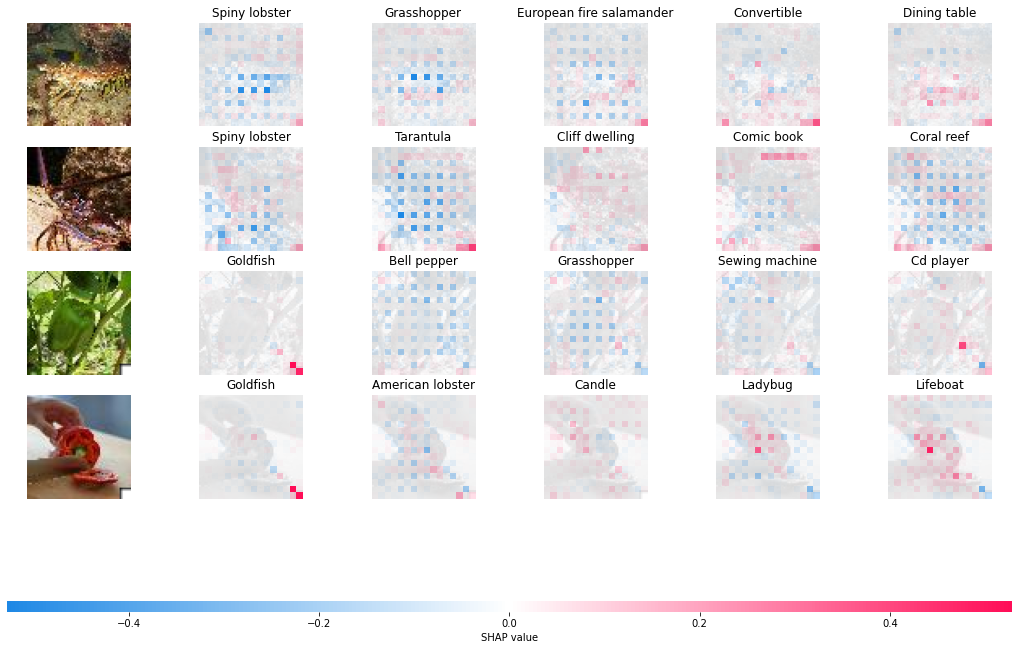

In [8]:
# Choose layer for SHAP for defense

if args.result_file_defense!='None':

    # Choose layer for SHAP
    if args.model == "preactresnet18":
        target_layer = model_defense.backbone.layer4 if defense_method=='dbd' else model_defense.layer4
    if args.model == "vgg19":
        target_layer = model_defense.backbone.features if defense_method=='dbd' else model_defense.features
    if args.model == "resnet18":
        target_layer = model_defense.backbone.layer4 if defense_method=='dbd' else model_defense.layer4
    if args.model == "densenet161": 
        target_layer = model_defense.backbone.features if defense_method=='dbd' else model_defense.features
    if args.model == "mobilenet_v3_large": 
        target_layer = model_defense.backbone.features if defense_method=='dbd' else model_defense.features
    if args.model == "efficientnet_b3":
        target_layer = model_defense.backbone.features if defense_method=='dbd' else model_defense.features

    model_defense.eval()

    outputs = model_defense(test_images)
    pre_p, pre_label = torch.max(sfm(outputs), dim=1)

    e = shap.GradientExplainer((model_defense, target_layer), background, local_smoothing=0)
    shap_values, indexes = e.shap_values(test_images, ranked_outputs=5)

    # get the names for the classes
    class_names = np.array(args.class_names).reshape([-1])
    index_names = np.vectorize(lambda x: class_names[x].capitalize())(indexes.cpu())
    # plot the explanations
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(
        np.swapaxes(denormalizer(test_images.cpu()).numpy(), 1, -1), 1, 2
    )
    test_numpy[test_numpy < 1e-12] = 1e-12  # for some numerical issue

    shap.image_plot(shap_numpy, test_numpy, index_names, show=False)
    plt.savefig(save_path_defense + f"/{args.result_file_defense.replace('/','_')}_shap.png")

    



### 2.3: GradCam

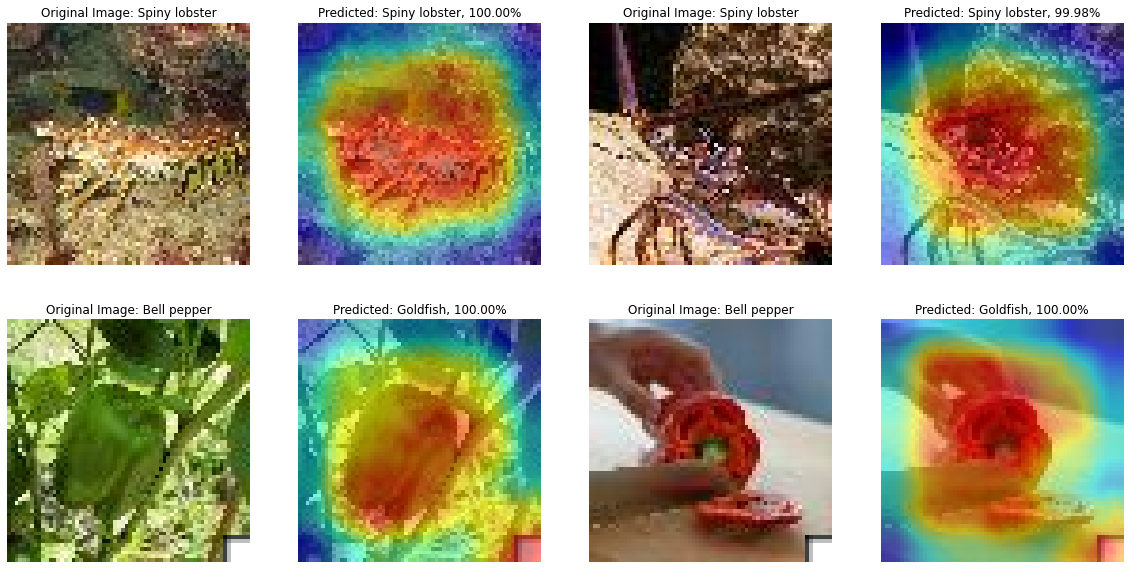

In [15]:
full_image = []
full_target = []
for batch_idx, (inputs, targets) in enumerate(data_loader):
    full_image.append(inputs)
    full_target.append(targets)
full_image_t = torch.cat(full_image, 0)
full_target_t = torch.cat(full_target, 0)

# choose data for visualization
n_v = 200
v_idx = np.random.choice(full_image_t.shape[0] - 4, n_v, replace=False)
background = full_image_t[2 + v_idx].to(args.device)
# background = full_image_t[-200:].to(args.device)

# 2 clean image + 2 poisoned image
test_images = torch.cat([full_image_t[:2], full_image_t[-2:]]).to(args.device)
# Get clean label for all test image
test_label = np.concatenate([y_v_clean[:2], y_v_clean[-2:]])

sfm = nn.Softmax(dim=1)

# choose layers for Grad Cam, refer to https://github.com/jacobgil/pytorch-grad-cam
if args.model == "preactresnet18":
    target_layers = [model_attack.layer4[-1]]
if args.model == "vgg19":
    target_layers = [model_attack.features[-1]]
if args.model == "resnet18":
    target_layers = [model_attack.layer4[-1]]
if args.model == "densenet161":
    target_layers = [model_attack.features[-1]]
if args.model == "mobilenet_v3_large":
    target_layers = [model_attack.features[-1]]
if args.model == "efficientnet_b3":
    target_layers = [model_attack.features[-1]]

input_tensor = test_images

outputs = model_attack(test_images)
pre_p, pre_label = torch.max(sfm(outputs), dim=1)

cam = FullGrad(model=model_attack, target_layers=target_layers, use_cuda=True)

targets = None

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam_full = cam(input_tensor=input_tensor, targets=targets)

grayscale_cam = grayscale_cam_full[0, :]
rgb_image = np.swapaxes(
    np.swapaxes(denormalizer(test_images[0]).cpu().numpy(), 0, 1), 1, 2
)
visual_cam = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
for im in range(4):
    grayscale_cam = grayscale_cam_full[im, :]
    rgb_image = np.swapaxes(
        np.swapaxes(denormalizer(test_images[im]).cpu().numpy(), 0, 1), 1, 2
    )
    rgb_image[rgb_image < 1e-12] = 1e-12
    visual_cam = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
    axes[im // 2, im % 2 * 2].imshow(rgb_image)
    axes[im // 2, im % 2 * 2].axis("off")
    axes[im // 2, im % 2 * 2].set_title(
        "Original Image: %s" % (class_names[test_label[im]].capitalize())
    )
    axes[im // 2, im % 2 * 2 + 1].imshow(visual_cam)
    axes[im // 2, im % 2 * 2 + 1].axis("off")
    axes[im // 2, im % 2 * 2 + 1].set_title(
        "Predicted: %s, %.2f%%" % (class_names[pre_label[im]].capitalize(), pre_p[im] * 100)
    )
plt.savefig(save_path_defense + f"/{args.result_file_attack.replace('/','_')}_cam.png")



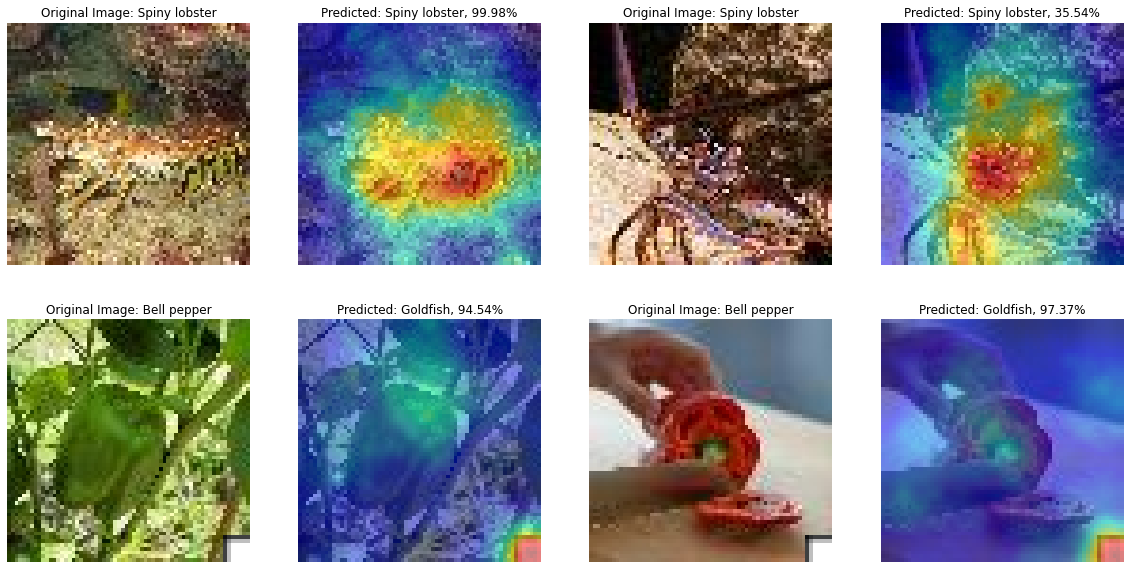

In [16]:
if args.result_file_defense!='None':
    # choose layers for Grad Cam, refer to https://github.com/jacobgil/pytorch-grad-cam
    if args.model == "preactresnet18":
        target_layer = [model_defense.backbone.layer4[-1]] if defense_method=='dbd' else [model_defense.layer4[-1]]
    if args.model == "vgg19":
        target_layer = [model_defense.backbone.features[-1]] if defense_method=='dbd' else [model_defense.features[-1]]
    if args.model == "resnet18":
        target_layer = [model_defense.backbone.layer4[-1]] if defense_method=='dbd' else [model_defense.layer4[-1]]
    if args.model == "densenet161": 
        target_layer = [model_defense.backbone.features[-1]] if defense_method=='dbd' else [model_defense.features[-1]]
    if args.model == "mobilenet_v3_large": 
        target_layer = [model_defense.backbone.features[-1]] if defense_method=='dbd' else [model_defense.features[-1]]
    if args.model == "efficientnet_b3":
        target_layer = [model_defense.backbone.features[-1]] if defense_method=='dbd' else [model_defense.features[-1]]

    input_tensor = test_images
    
    outputs = model_defense(test_images)
    pre_p, pre_label = torch.max(sfm(outputs), dim=1)

    cam = FullGrad(model=model_defense, target_layers=target_layers, use_cuda=True)

    targets = None

    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam_full = cam(input_tensor=input_tensor, targets=targets)

    grayscale_cam = grayscale_cam_full[0, :]
    rgb_image = np.swapaxes(
        np.swapaxes(denormalizer(test_images[0]).cpu().numpy(), 0, 1), 1, 2
    )
    visual_cam = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)


    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    for im in range(4):
        grayscale_cam = grayscale_cam_full[im, :]
        rgb_image = np.swapaxes(
            np.swapaxes(denormalizer(test_images[im]).cpu().numpy(), 0, 1), 1, 2
        )
        rgb_image[rgb_image < 1e-12] = 1e-12
        visual_cam = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
        axes[im // 2, im % 2 * 2].imshow(rgb_image)
        axes[im // 2, im % 2 * 2].axis("off")
        axes[im // 2, im % 2 * 2].set_title(
            "Original Image: %s" % (class_names[test_label[im]].capitalize())
        )
        axes[im // 2, im % 2 * 2 + 1].imshow(visual_cam)
        axes[im // 2, im % 2 * 2 + 1].axis("off")
        axes[im // 2, im % 2 * 2 + 1].set_title(
            "Predicted: %s, %.2f%%" % (class_names[pre_label[im]].capitalize(), pre_p[im] * 100)
        )
    plt.savefig(save_path_defense + f"/{args.result_file_defense.replace('/','_')}_cam.png")

